<a href="https://colab.research.google.com/github/lszam/gds-ssebrazil/blob/main/GDS_SSEBrazil_Etapa1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Etapa 1 - obtendo dados**

Este arquivo foi desenvolvido para ser executado em ambiente Google Colab.

Para fins de simplificação do processo de análise de dados como um todo, é solicitado ao usuário deste Notebook que seus arquivos de entrada estejam minimamente padronizados nos seguintes aspectos:

- O código espera arquivos shapefile compactados como arquivos .zip.
- Os produtos de entrada precisam conter as coordenadas nas colunas LATITUDE e LONGITUDE em Sirgas 2000 (datum oficial do Brasil).
- O valor da gravidade observada deve estar no campo GRAV_OBS, e a altitude ortométrica como ALT_ORTOMETRICA.
- Se houver o campo de anomalia ar livre calculado, será considerado em etapa futura caso esteja nomeado como GRAV_ARLIVRE. De qualquer modo, este valor será recalculado posteriormente.

# **Preparar o ambiente e arquivos de entrada**

In [5]:
!pip install geopandas shapely matplotlib zipfile36 -q

import zipfile
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt


def unzip_files(file_paths, extract_dir='/content/SHP'):
  '''
  Função para descompactar arquivos .zip no Google Colab
  '''
  os.makedirs(extract_dir, exist_ok=True)
  shapefiles = []
  for file_path in file_paths:
      zip_name = os.path.basename(file_path).replace('.zip', '')  # Nome do arquivo zip sem a extensão
      with zipfile.ZipFile(file_path, 'r') as zip_ref:
          zip_ref.extractall(extract_dir)
          # Adicionar shapefiles e o nome do arquivo zip como origem
          shapefiles.extend([(os.path.join(extract_dir, name), zip_name)
                              for name in zip_ref.namelist() if name.endswith('.shp')])
  return shapefiles

def plot_2maps(gdf1, title1, color1, gdf2, title2, color2, brasil_contour):
    """
    Função para plotar dois mapas do Brasil, para situações onde seja necessário comparar dados.
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # 2 subplots

    # Mapa de pontos que vão ser considerados no projeto
    brasil_contour.plot(ax=axes[0], color='none', edgecolor='black')
    gdf1.plot(ax=axes[0], color=color1, markersize=0.5, alpha=0.7)
    axes[0].set_title(title1, fontsize=16)
    axes[0].set_xlabel('Longitude', fontsize=14)
    axes[0].set_ylabel('Latitude', fontsize=14)
    axes[0].tick_params(axis='both', which='major', labelsize=12)
    axes[0].grid(True)

    # Mapa com pontos duplicados, que serão retirados
    brasil_contour.plot(ax=axes[1], color='none', edgecolor='black')
    gdf2.plot(ax=axes[1], color=color2, markersize=5, alpha=0.7)
    axes[1].set_title(title2, fontsize=16)
    axes[1].set_xlabel('Longitude', fontsize=14)
    axes[1].set_ylabel('Latitude', fontsize=14)
    axes[1].tick_params(axis='both', which='major', labelsize=12)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

Faça o upload dos arquivos a serem mesclados

In [2]:
# Upload dos arquivos ZIP
from google.colab import files
uploaded = files.upload()

# Caminhos dos arquivos ZIP
file_paths = [f'/content/{name}' for name in uploaded.keys()]

Saving bndg-2023-shp.zip to bndg-2023-shp.zip
Saving ibge-2023.zip to ibge-2023.zip
Saving sgb-nov2024-shp.zip to sgb-nov2024-shp.zip


# Concatenar dados

Descompactar os arquivos e combinar em 1 único objeto tipo gdf

In [8]:
shapefiles = unzip_files(file_paths)

# Ler e concatenar objetos gdf
gdf_list = []
for shp_path, source_name in shapefiles:
    gdf = gpd.read_file(shp_path)

    # Garantir que todos os shapefiles usem o CRS SIRGAS 2000
    if gdf.crs is None:
        gdf.set_crs("EPSG:4674", inplace=True)
    else:
        gdf = gdf.to_crs("EPSG:4674")

    # Salvar o nome do arquivo zip no objeto
    gdf['source_file'] = source_name
    gdf_list.append(gdf)


combined_gdf = pd.concat(gdf_list, ignore_index=True) # combinação

Verificar pontos duplicados, com base nos campos LATITUDE e LONGITUDE. Está sendo considerado que o valor da coordenada arredondado em 6 casas possui precisão suficiente.

In [9]:
combined_gdf['LATITUDE'] = combined_gdf['LATITUDE'].round(6) #precisão da coordenada em 6 casas
combined_gdf['LONGITUDE'] = combined_gdf['LONGITUDE'].round(6)

# Mascara com dados duplicados
duplicated_mask = combined_gdf.duplicated(subset=['LATITUDE', 'LONGITUDE'], keep=False)

# Separar os pontos duplicados e não duplicados
duplicated_gdf = combined_gdf[duplicated_mask]
unique_gdf = combined_gdf[~duplicated_mask]

Plotar os mapas dos dados no Brasil

In [10]:
# Baixar o shapefile das unidades da federação (UFs) do Brasil do site do IBGE
!wget -O brasil.zip https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2021/Brasil/BR/BR_UF_2021.zip
!unzip brasil.zip -d /content/brasil_shapefile

brasil = gpd.read_file('/content/brasil_shapefile/BR_UF_2021.shp')

--2024-11-16 20:48:33--  https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2021/Brasil/BR/BR_UF_2021.zip
Resolving geoftp.ibge.gov.br (geoftp.ibge.gov.br)... 191.233.136.86
Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|191.233.136.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13648228 (13M) [application/zip]
Saving to: ‘brasil.zip’

brasil.zip          100%[===================>]  13.02M  4.05MB/s    in 3.2s    

2024-11-16 20:48:38 (4.05 MB/s) - ‘brasil.zip’ saved [13648228/13648228]

Archive:  brasil.zip
 extracting: /content/brasil_shapefile/BR_UF_2021.cpg  
  inflating: /content/brasil_shapefile/BR_UF_2021.dbf  
  inflating: /content/brasil_shapefile/BR_UF_2021.prj  
  inflating: /content/brasil_shapefile/BR_UF_2021.shp  
  inflating: /content/brasil_shapefile/BR_UF_2021.shx  


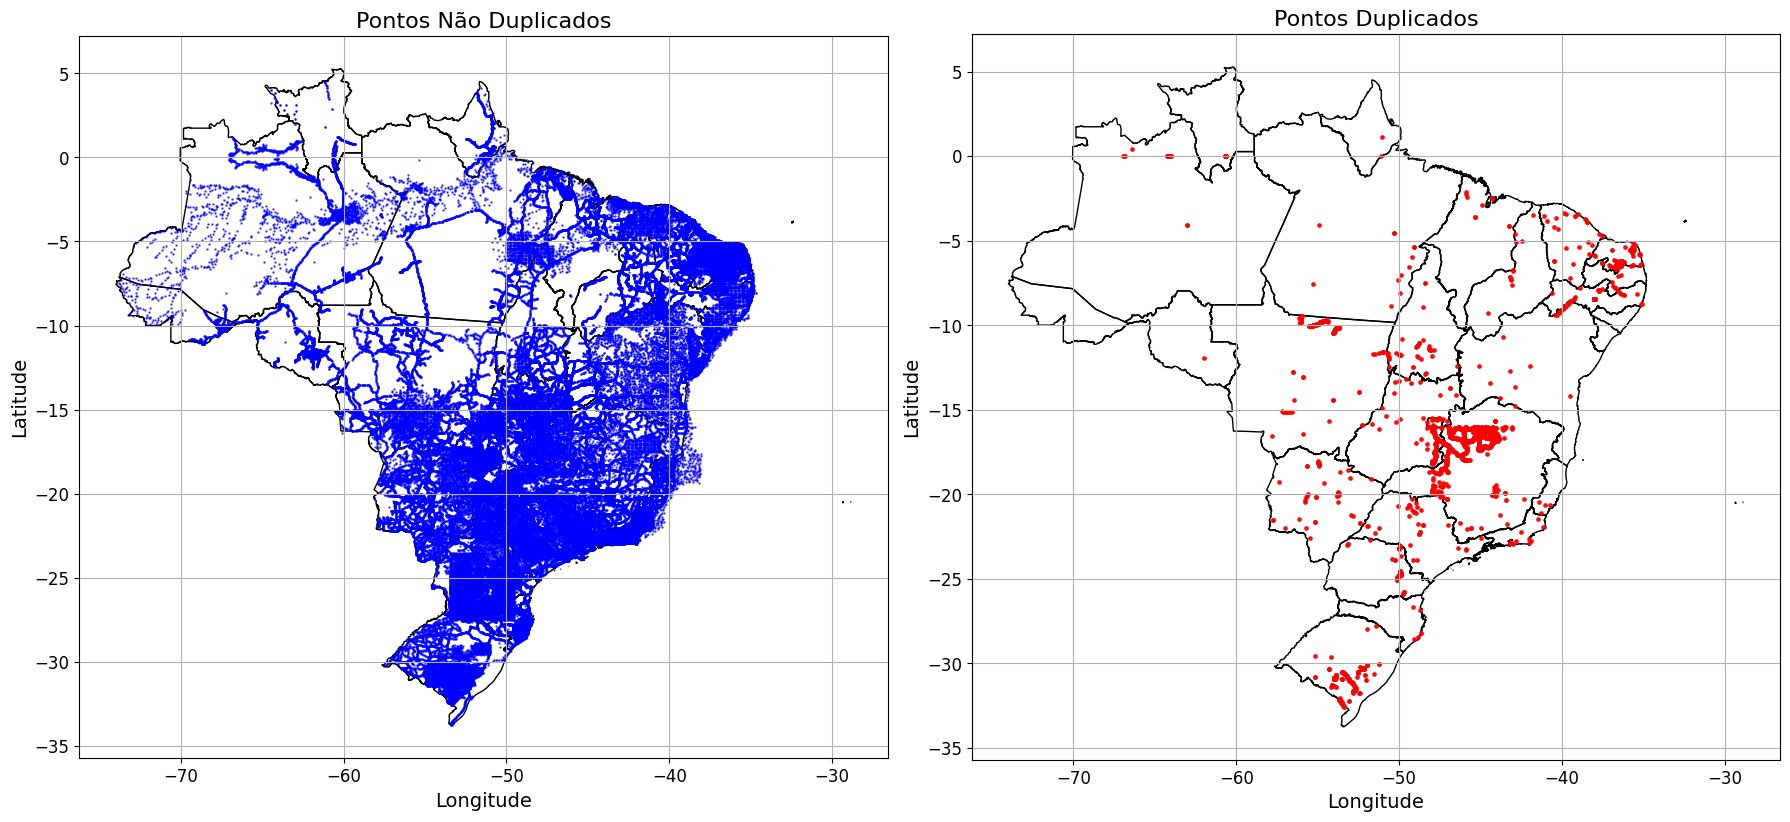

In [11]:
plot_2maps(
    unique_gdf, 'Pontos Não Duplicados', 'blue',
    duplicated_gdf, 'Pontos Duplicados', 'red',
    brasil
)

# **Salvar saídas**

In [12]:
# Salvar dados resultantes como shapefiles

output_dir = '/content/OUTPUT'
os.makedirs(output_dir, exist_ok=True)

unique_gdf.to_file(os.path.join(output_dir, 'grav.shp'))

duplicated_gdf.to_file(os.path.join(output_dir, 'grav_duplicata.shp'))

# Fazer download dos shapefiles salvos
import shutil
shutil.make_archive('/content/OUTPUT', 'zip', output_dir)

# Exibir link para download dos arquivos
from google.colab import files
files.download('/content/OUTPUT.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>